In [1]:
import pnet_loader
import util
import Pnet
import ReactomeNetwork
import torch
import random
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import torch.nn.functional as F
import torch.nn as nn


%load_ext autoreload
%autoreload 2

In [2]:
paths = ['lusc_tcga_pan_can_atlas_2018', 'luad_tcga_pan_can_atlas_2018', 'brca_tcga_pan_can_atlas_2018']
paths = ['../../data/'+ p for p in paths]

In [3]:
lusc_rna, lusc_cna, lusc_tumor_type, lusc_mut = util.load_tcga_dataset(paths[0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [4]:
luad_rna, luad_cna, luad_tumor_type, luad_mut = util.load_tcga_dataset(paths[1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [5]:
brca_rna, brca_cna, brca_tumor_type, brca_mut = util.load_tcga_dataset(paths[2])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [6]:
rna = pd.concat([lusc_rna, luad_rna, brca_rna]).dropna(axis=1)
rna = (rna-rna.mean())/rna.std()
rna = rna.dropna(axis=1)
cna = pd.concat([lusc_cna, luad_cna, brca_cna]).dropna(axis=1)
mut = pd.concat([lusc_mut, luad_mut, brca_mut]).dropna(axis=1)
tumor_type = pd.concat([lusc_tumor_type, luad_tumor_type, brca_tumor_type])

In [7]:
genetic_data = {'cna': cna, 'mut': mut}

In [8]:
class_counts = tumor_type['tumor'].value_counts()

# Find the class with the least samples
min_samples = class_counts.min()

# Balance the DataFrame by randomly sampling the same number of samples for each class
balanced_samples = []
for _, group in tumor_type.groupby('tumor'):
    balanced_samples.extend(group.sample(n=min_samples, random_state=42).index)

# Create the balanced DataFrame with the selected samples
balanced_tumor_type = tumor_type.loc[balanced_samples]

In [9]:
# from sklearn.model_selection import StratifiedKFold

# tumor_type_inds = pnet_loader.get_indicies(genetic_data, pd.get_dummies(balanced_tumor_type))
# y = list(tumor_type.loc[tumor_type_inds]['tumor'])
# # Assuming `y` contains the labels for your training data
# # and `prostate_inds` contains the indices of the training data
# # Make sure `y` and `prostate_inds` have the same length

# # Create an instance of StratifiedKFold with 10 splits
# skf = StratifiedKFold(n_splits=5)

# # Initialize an empty list to store the sublists of indices
# sublists = []

# # Split the indices into sublists stratified by labels
# for train_index, _ in skf.split(tumor_type_inds, y):
#     sublist = [tumor_type_inds[i] for i in train_index]
#     sublists.append(sublist)
    
# for i, s in enumerate(sublists):
#     s_ = [x for x in tumor_type_inds if x not in s]
#     train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, pd.get_dummies(balanced_tumor_type), train_inds=s, test_inds=s_)
#     train_dataset.save_indicies('../data/splits/tumor_type/train_set_{}.csv'.format(i))
#     test_dataset.save_indicies('../data/splits/tumor_type/test_set_{}.csv'.format(i))

In [10]:
canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))

Task defined: MC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1452 overlapping indicies
Initializing Train Dataset
Found 687 overlapping genes
generated input DataFrame of size (930, 1374)
Initializing Test Dataset
Found 687 overlapping genes
generated input DataFrame of size (238, 1374)
Found 687 overlapping genes
Loss function used: CrossEntropyLoss()
We are sending to cuda
Task defined: MC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1452 overlapping indicies
Initializing Train Dataset
Found 687 overlapping genes
generated input DataFrame of size (936, 1374)
Initializing Test Dataset
Found 687 overlapping genes
generated input DataFrame of size (232, 1374)
Found 687 overlapping genes
Loss function used: CrossEntropyLoss()
We are sending to cuda
Hit early stopping criteria
Task defined: MC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1452 overlapping indicies
Ini

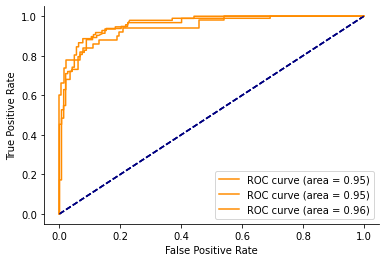

In [15]:
for i in range(5):
    train_inds = list(pd.read_csv('../data/splits/tumor_type/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/tumor_type/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, pd.get_dummies(balanced_tumor_type), seed=0, dropout=0.2, lr=1e-3, weight_decay=1e-3,
                                                                           batch_size=64, epochs=300, early_stopping=True, train_inds=train_inds,
                                                                           test_inds=test_inds, input_dropout=0.5, gene_set=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/tumor_type/run{}'.format(i))

Task defined: MC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1452 overlapping indicies
Initializing Train Dataset
Found 687 overlapping genes
generated input DataFrame of size (930, 1374)
Initializing Test Dataset
Found 687 overlapping genes
generated input DataFrame of size (238, 1374)
Found 687 overlapping genes
Loss function used: CrossEntropyLoss()
We are sending to cuda
Hit early stopping criteria
Task defined: MC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1452 overlapping indicies
Initializing Train Dataset
Found 687 overlapping genes
generated input DataFrame of size (936, 1374)
Initializing Test Dataset
Found 687 overlapping genes
generated input DataFrame of size (232, 1374)
Found 687 overlapping genes
Loss function used: CrossEntropyLoss()
We are sending to cuda
Hit early stopping criteria
Task defined: MC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1

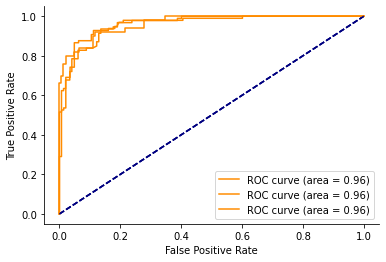

In [21]:
for i in range(5):
    train_inds = list(pd.read_csv('../data/splits/tumor_type/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/tumor_type/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, pd.get_dummies(balanced_tumor_type), seed=0, dropout=0.2, lr=1e-3, weight_decay=1e-3,
                                                                           batch_size=64, epochs=300, early_stopping=True, train_inds=train_inds,
                                                                           test_inds=test_inds, input_dropout=0.5, gene_set=canc_genes, random_network=True)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/tumor_type_random_net/run{}'.format(i))

Task defined: MC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1452 overlapping indicies
Initializing Train Dataset
Found 687 overlapping genes
generated input DataFrame of size (930, 1374)
Initializing Test Dataset
Found 687 overlapping genes
generated input DataFrame of size (238, 1374)
Found 687 overlapping genes
Loss function used: CrossEntropyLoss()
We are sending to cuda
Hit early stopping criteria
Task defined: MC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1452 overlapping indicies
Initializing Train Dataset
Found 687 overlapping genes
generated input DataFrame of size (936, 1374)
Initializing Test Dataset
Found 687 overlapping genes
generated input DataFrame of size (232, 1374)
Found 687 overlapping genes
Loss function used: CrossEntropyLoss()
We are sending to cuda
Hit early stopping criteria
Task defined: MC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1

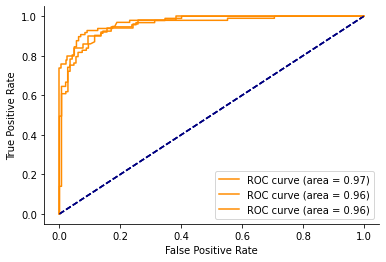

In [22]:
for i in range(5):
    train_inds = list(pd.read_csv('../data/splits/tumor_type/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/tumor_type/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, pd.get_dummies(balanced_tumor_type), seed=0, dropout=0.2, lr=1e-3, weight_decay=1e-3,
                                                                           batch_size=64, epochs=300, early_stopping=True, train_inds=train_inds,
                                                                           test_inds=test_inds, input_dropout=0.5, gene_set=canc_genes, fcnn=True)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/tumor_type_fcnn/run{}'.format(i))

In [ ]:
for i in range(5):
    path = '../results/tumor_type_rf/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_inds = list(pd.read_csv('../data/splits/tumor_type/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/tumor_type/test_set_{}.csv'.format(i))['indicies'])
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=pd.get_dummies(balanced_tumor_type), train_inds=train_inds,
                                                                  test_inds=test_inds, gene_set=canc_genes)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    rfc = RandomForestClassifier(max_depth=None, random_state=0)
    rfc.fit(x_train, y_train)
    preds = rfc.predict(x_test)
    preds_prob = rfc.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_test)
    importances = rfc.feature_importances_
    forest_importances = pd.Series(importances, index=test_dataset.input_df.columns)
    forest_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')

In [34]:
aucs = []
for i in range(5):
    auc_ = torch.load('../results/tumor_type/run{}/AUC.pt'.format(i))
    aucs.append(auc_)

In [35]:
torch.tensor(aucs).mean(axis=0)

tensor([0.9747, 0.9610, 0.9631], dtype=torch.float64)

In [37]:
aucs = []
for i in range(5):
    auc_ = torch.load('../results/tumor_type_random_net/run{}/AUC.pt'.format(i))
    aucs.append(auc_)

In [38]:
torch.tensor(aucs).mean(axis=0)

tensor([0.9766, 0.9592, 0.9634], dtype=torch.float64)

In [39]:
aucs = []
for i in range(5):
    auc_ = torch.load('../results/tumor_type_fcnn/run{}/AUC.pt'.format(i))
    aucs.append(auc_)

In [41]:
torch.tensor(aucs).mean(axis=0)

tensor([0.9716, 0.9582, 0.9604], dtype=torch.float64)

In [42]:
rank_stab = {}
for m in ['', '_fcnn', '_random_net']:
    df = pd.DataFrame()
    for i in range(5):
        imps = pd.read_csv('../results/tumor_type{}/run{}/gene_importances.csv'.format(m, i)).set_index('Unnamed: 0')
        ranks = abs(imps).mean().rank(ascending=False)
        df['run{}'.format(i)] = ranks

    most_imp_50 = df.mean(axis=1).nsmallest(50).index
    rank_stab[m] = df.loc[most_imp_50].std(axis=1).mean()
    # filtered_df = df[~(df > 20).any(axis=1)]
    # rank_stab[m] = filtered_df.shape[0]

In [43]:
rank_stab

{'': 36.21700924408011,
 '_fcnn': 84.11271368261558,
 '_random_net': 34.120980350721766}